In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 


In [5]:


latent_dims = 8
num_epochs = 500
batch_size = 4
capacity = 10
learning_rate = 1e-4

use_gpu = True

In [6]:
import os
import descriptors
import numpy as np

dict_r = np.load('data_dict_jerem_v1.npy', allow_pickle=True).item()

train_db = np.zeros([len(dict_r['env']),2,750])


i = 0
for sample in dict_r['env']:
    train_db[i,:,:] = sample
    i+=1



MAX1 = np.max(train_db[:,0,:])
MAX2 = np.max(train_db[:,1,:])
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= (MAX2)
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))

print(train_db.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
print(len(train_loader))
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

(218, 2, 750)
54


In [3]:

from torch.utils.data import random_split

import os
import descriptors
import numpy as np


dict_r = np.load('data_dict.npy', allow_pickle=True).item()


print(len(dict_r['env']))

train_db_l, test_db_l = random_split((dict_r['env']), [220, 32])
print(len(train_db_l))
print(len(test_db_l))


train_db = np.zeros([len(train_db_l),2,750])
test_db = np.zeros([len(train_db_l),2,750])

i = 0
for sample in train_db_l:
    train_db[i,:,:] = sample
    i+=1


i = 0
for sample in test_db_l:
    test_db[i,:,:] = sample
    i+=1
    
i = 0
for sample in train_db:
    test_db[i,:,:] = sample
    i+=1
#train_db+=(np.random.randn(*train_db.shape)/1000)

    
MAX1 = np.max(train_db[:,0,:])
MAX2 = np.max(train_db[:,1,:])
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= (MAX2)*20

MAX11 = np.max(test_db[:,0,:])
MAX22 = np.max(test_db[:,1,:])
test_db[:,0,:] /= MAX11
test_db[:,1,:] /= (MAX22)*20

train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))
test_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(test_db))

print(train_db.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
print(len(train_loader))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last = True)




0


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [5]:
print(len('data_dict.npy'))

13


In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity     
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=10, stride=2, padding=7), nn.BatchNorm1d(c),nn.Dropout(p=0.2)) # out: c, 372
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=5, stride=2, padding=7), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c*4, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*8, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(8*c),nn.Dropout(p=0.2)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2)) # out: c*2, 186
        self.lin1 = nn.Linear(8*c*49, latent_dims)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin1(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.lin1 = nn.Linear(latent_dims, 8*c*49)
        self.conv5 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2, output_padding=0), nn.BatchNorm1d(c*8))
        self.conv4 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=2, padding=2, output_padding=0), nn.BatchNorm1d(c*4))
        self.conv3 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=2, padding=2, output_padding=1), nn.BatchNorm1d(c*2))
        self.conv2 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=5, stride=2, padding=7, output_padding=1), nn.BatchNorm1d(c))
        
        self.conv1 = nn.Sequential(nn.ConvTranspose1d(in_channels=c, out_channels=2, kernel_size=10, stride=2, padding=7, output_padding=0))
            
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = x.view(x.size(0), capacity*8, 49) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x_recon = self.decoder(x)
        return x_recon
    
def ae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    return recon_loss
    
ae = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
ae = ae.to(device)

num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 174030


In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity     
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=5)) # out: c, 372
        self.lin0= nn.Linear(c*49, c*20)
        self.lin1 = nn.Linear(c*20, latent_dims) 
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin0(x))
        x = F.relu(self.lin1(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.lin1 = nn.Linear(latent_dims, c*20)
        self.lin0 = nn.Linear(c*20, c*49)
        self.conv1 = nn.Sequential(nn.ConvTranspose1d(in_channels=c, out_channels=2, kernel_size=10, stride=2, padding=7, output_padding=0), nn.BatchNorm1d(2))
            
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin0(x))
        x = x.view(x.size(0), capacity, 49) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x_recon = self.decoder(x)
        return x_recon
    
def ae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    return recon_loss
    
ae = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
ae = ae.to(device)

num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 200414


# Entrainement

In [10]:
optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
ae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in train_loader:

        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0]).to(device)
        image_batch = image_batch.view(batch_size,2,750)
        
        # vae reconstruction
        image_batch_recon = ae(image_batch.float())
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch.float())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()

        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 500] average reconstruction error: 0.121825
Epoch [2 / 500] average reconstruction error: 0.097539
Epoch [3 / 500] average reconstruction error: 0.081583
Epoch [4 / 500] average reconstruction error: 0.069426
Epoch [5 / 500] average reconstruction error: 0.059131
Epoch [6 / 500] average reconstruction error: 0.050406
Epoch [7 / 500] average reconstruction error: 0.042844
Epoch [8 / 500] average reconstruction error: 0.037817
Epoch [9 / 500] average reconstruction error: 0.032369
Epoch [10 / 500] average reconstruction error: 0.028620
Epoch [11 / 500] average reconstruction error: 0.026391
Epoch [12 / 500] average reconstruction error: 0.023920
Epoch [13 / 500] average reconstruction error: 0.021266
Epoch [14 / 500] average reconstruction error: 0.020232
Epoch [15 / 500] average reconstruction error: 0.017870
Epoch [16 / 500] average reconstruction error: 0.016303
Epoch [17 / 500] average reconstruction error: 0.014927
Epoch [18 / 500] average reconstruction erro

# Affichage de la courbe de Loss

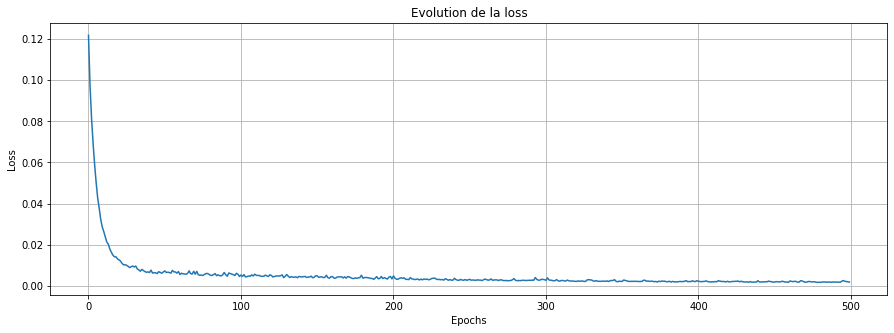

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la loss')
plt.grid()
plt.show()

# Reconstruction 

data_2_jerem\Vn-avf-ff-1c-A#3.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


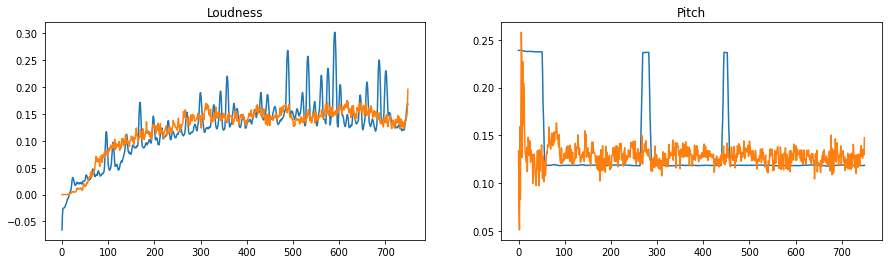

data_2_jerem\Vn-avf-ff-1c-A#4.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


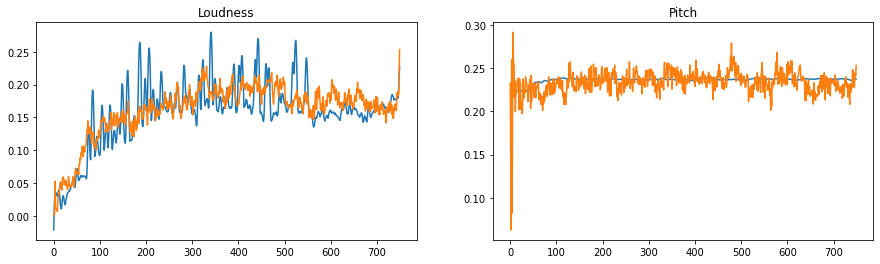

data_2_jerem\Vn-avf-ff-1c-A#5.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


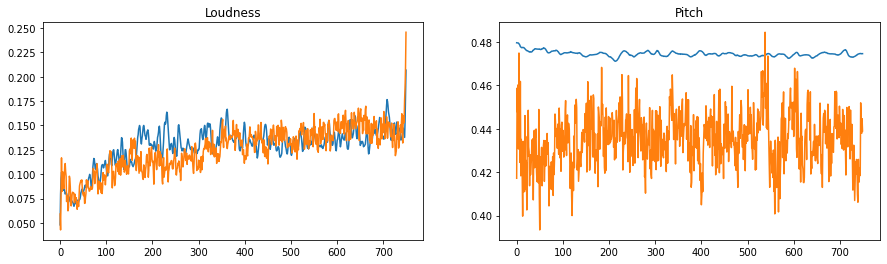

data_2_jerem\Vn-avf-ff-1c-A3.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


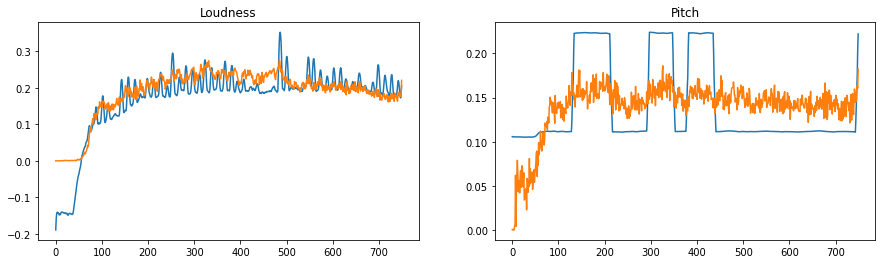

c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


data_2_jerem\Vn-avf-ff-1c-A4.wav
Image originale
VAE reconstruction:


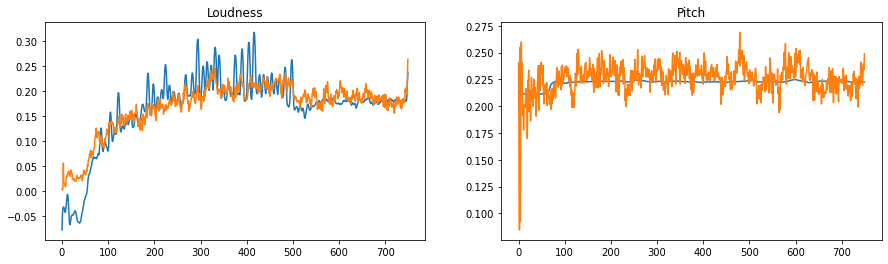

data_2_jerem\Vn-avf-ff-1c-A5.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


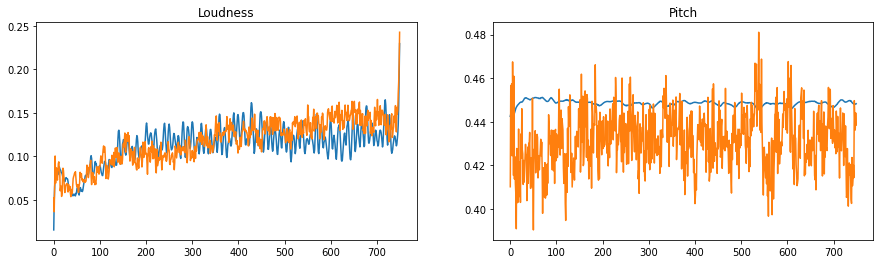

data_2_jerem\Vn-avf-ff-1c-B3.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


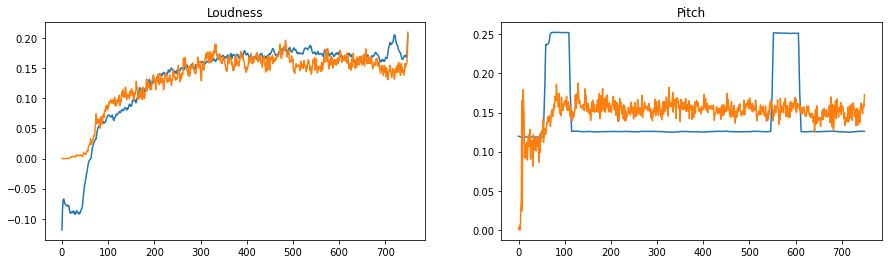

data_2_jerem\Vn-avf-ff-1c-B4.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


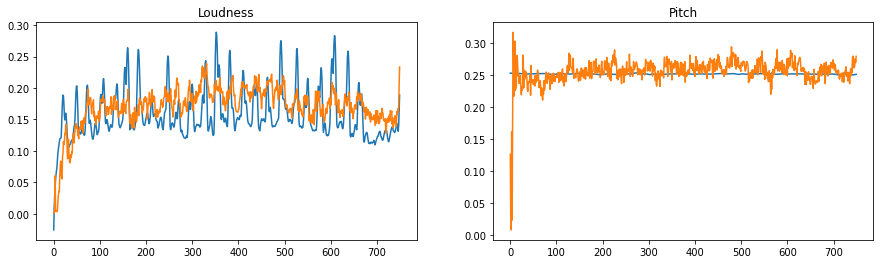

data_2_jerem\Vn-avf-ff-1c-B5.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


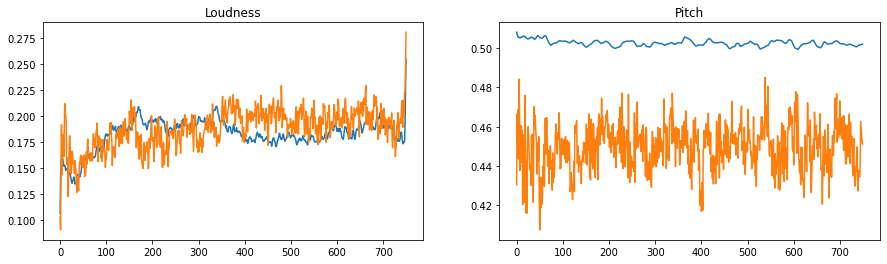

data_2_jerem\Vn-avf-ff-1c-C#4.wav
Image originale
VAE reconstruction:


c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


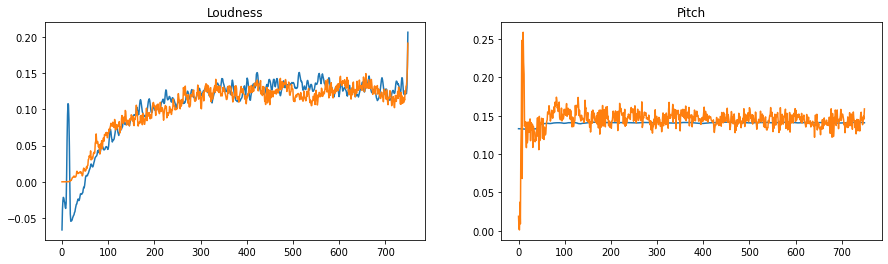

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

ae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction

for i in range(10):
    images = train_db[i,:,:]
    # Affichage de l'image originale
    print(dict_r['file_name'][i])
    print('Image originale')

    plt.figure(i,figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot((images[0,:]), label='Original')
    plt.title('Loudness')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(images[1,:], label='Original')  
    plt.grid()
    plt.title('Pitch')
  
    # Reconstruct and visualise the images using the vae
    print('VAE reconstruction:')
    ae=ae.cpu()
    images_recon = ae(torch.from_numpy(images).view(1,2,750).float())
    images_recon = images_recon.detach().numpy()
    plt.figure(i,figsize=(20,4))
    plt.subplot(1,2,1)
    plt.grid()
    plt.plot(images_recon[0,0,:], label='Reconstruit')
    plt.subplot(1,2,2)
    plt.plot(images_recon[0,1,:], label='Reconstruit')
    #ymin, ymax = plt.ylim()
    #plt.ylim(ymin , ymax / )
    plt.grid()
    plt.show()



In [ ]:
 # Specify a path
PATH = "model_ae.pt"

# Save
torch.save(ae, PATH)                                                                                   
#Load (pour le magnifique visualizer)                         
model = torch.load(PATH)